<a href="https://colab.research.google.com/github/hee-chang/deeplearning/blob/main/Mini_Project_3_150_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

구글 드라이브 마운트 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


라이브러리 패키지

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import librosa
import librosa.display

from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda, Layer, Embedding, LayerNormalization

Read csv file

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UrbanSound_datasets/UrbanSound/UrbanSound8K.csv")

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Dataset preprocessing,
Split dataset

In [ ]:
feature = []
label = []

def mfcc_maker():
    for i in range(8732):
        file_name = '/content/drive/MyDrive/UrbanSound_datasets/UrbanSound/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        data, sampling_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate)
        z = np.zeros((20, 174))
        z[:mfcc.shape[0], :mfcc.shape[1]] = mfcc
        feature.append(z)
        label.append(df["classID"][i])
        print(i+1)
    return feature, label

x, y = mfcc_maker()

x = tf.cast(x, tf.float32)

train_validation_ds = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(10000)

n_train = 5732
n_validation = 1500

train_ds = train_validation_ds.take(n_train).batch(32)
remaining_ds = train_validation_ds.skip(n_train)
validation_ds = remaining_ds.take(n_validation).batch(32)
remaining2_ds = remaining_ds.skip(n_validation)
test_ds = remaining2_ds.take(n_validation).batch(1)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925

RNN Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

Training, validation loop

In [ ]:
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def validation_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images)

    v_loss = loss_object(labels, predictions)
    test_loss(v_loss)
    test_accuracy(labels, predictions)

모델 생성, 손실함수, 최적화 알고리즘, 평가지표 정의

In [ ]:
# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name = 'validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'validation_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

하이퍼 파라미터 설정

In [ ]:
EPOCHS = 150

학습 루프 동작

In [ ]:
train_loss_history = []
train_acc_history = []
validation_loss_history = []
validation_acc_history = []
start = time.time()

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)
        
    for v_images, v_labels in validation_ds:
        validation_step(model, v_images, v_labels, loss_object, validation_loss, validation_accuracy)
    
    template = 'Epoch {}\n Loss: {:.4f}, Accuracy: {:.2f}%\n Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%\n'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          validation_loss.result(),
                          validation_accuracy.result()*100))
    
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result()*100)
    validation_loss_history.append(validation_loss.result())
    validation_acc_history.append(validation_accuracy.result()*100)
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()

print("time :", time.time() - start)

Epoch 1
 Loss: 2.1957, Accuracy: 17.38%
 Validation Loss: 2.0263, Validation Accuracy: 26.00%

Epoch 2
 Loss: 2.0107, Accuracy: 26.33%
 Validation Loss: 1.9189, Validation Accuracy: 30.80%

Epoch 3
 Loss: 1.9210, Accuracy: 29.45%
 Validation Loss: 1.8463, Validation Accuracy: 31.40%

Epoch 4
 Loss: 1.8365, Accuracy: 33.85%
 Validation Loss: 1.7549, Validation Accuracy: 38.47%

Epoch 5
 Loss: 1.7648, Accuracy: 37.02%
 Validation Loss: 1.7149, Validation Accuracy: 39.47%

Epoch 6
 Loss: 1.7167, Accuracy: 37.89%
 Validation Loss: 1.6331, Validation Accuracy: 44.53%

Epoch 7
 Loss: 1.6505, Accuracy: 41.66%
 Validation Loss: 1.5865, Validation Accuracy: 44.60%

Epoch 8
 Loss: 1.6031, Accuracy: 43.61%
 Validation Loss: 1.5354, Validation Accuracy: 46.60%

Epoch 9
 Loss: 1.5553, Accuracy: 44.84%
 Validation Loss: 1.5325, Validation Accuracy: 46.87%

Epoch 10
 Loss: 1.5221, Accuracy: 45.90%
 Validation Loss: 1.4744, Validation Accuracy: 49.33%

Epoch 11
 Loss: 1.4938, Accuracy: 46.16%
 Validat

Plot training, validation loss

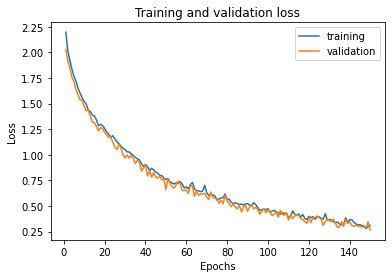

In [ ]:
epochs = range(1, EPOCHS + 1)

plt.plot(epochs, train_loss_history)
plt.plot(epochs, validation_loss_history)
plt.title('Training and validation loss')
plt.legend(['training', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Plot training, validation accuracy

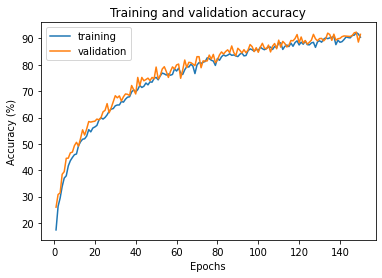

In [ ]:
plt.plot(epochs, train_acc_history)
plt.plot(epochs, validation_acc_history)
plt.title('Training and validation accuracy')
plt.legend(['training', 'validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

Test dataset의 loss, accuracy 측정

In [ ]:
pred_datasets = []
labels = []

for t_image, t_label in test_ds:
    predictions = model(t_image)
    y_pred=np.argmax(predictions)
    pred_datasets.append(y_pred)
    labels.append(t_label)
    
    v_loss = loss_object(t_label, predictions)
    test_loss(v_loss)
    test_accuracy(t_label, predictions)

template = 'Test Loss: {:.4f}, Test Accuracy: {:.2f}%\n'
print(template.format(test_loss.result(), test_accuracy.result()*100))

Test Loss: 0.2928, Test Accuracy: 91.90%



Test dataset의 confusion matrix 생성

In [ ]:
con_mat = tf.math.confusion_matrix(labels=labels, predictions=pred_datasets, num_classes= 10).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

Confusion matrix 시각화

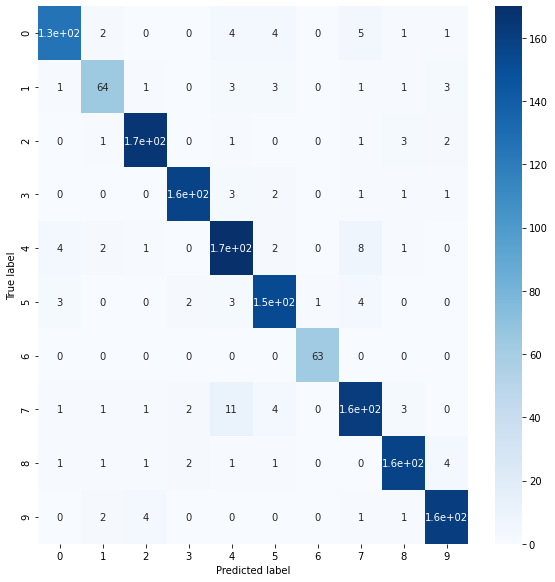

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Normalized confusion matrix 시각화

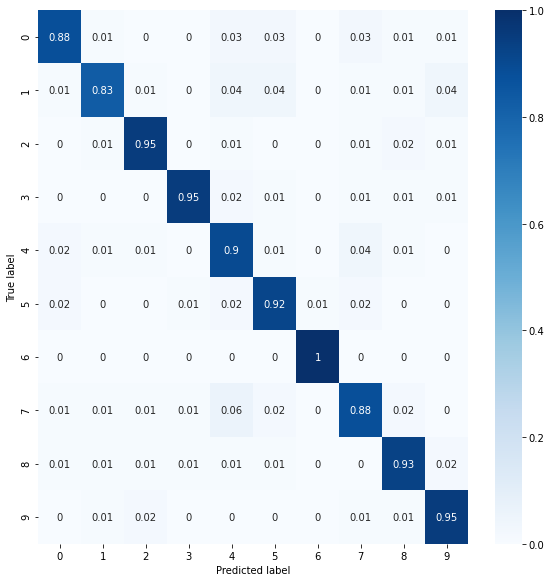

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()